In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
url = '/content/drive/My Drive/WashU/courses/DL-Business/Project/'
df = pd.read_csv(url + 'train.csv')
df = df.rename(columns={'comment_text': 'text'})

In [ ]:
df.iloc[10:15, :]

,id,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
10,0005300084f90edc,"""\nFair use rationale for Image:Wonju.jpg\n\nT...",0,0,0,0,0,0
11,00054a5e18b50dd4,bbq \n\nbe a man and lets discuss it-maybe ove...,0,0,0,0,0,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
13,0006f16e4e9f292e,Before you start throwing accusations and warn...,0,0,0,0,0,0
14,00070ef96486d6f9,"Oh, and the girl above started her arguments w...",0,0,0,0,0,0


In [ ]:
df.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

## Data Preprocessing

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:

# Remove Punctuation, stemming ,and lemmatizing

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stop = stopwords.words('english')
wnl = nltk.stem.WordNetLemmatizer()
stem = SnowballStemmer("english")

def stem_lem(text):
    punc = '[":;><|=}{})(&*1234567890*%$!,.:?•<>/\^+@-]'
    text = text.replace(punc,'')

    
    words =text.split(" ")
    text = [wnl.lemmatize(word) for word in words]
    text = " ".join(text)
    words =text.split(" ")
    text = [stem.stem(word)for word in words]
    text = " ".join(text)

    return text




def clean(data, col):
 

  # Clean puncuations and space
    data[col] = data[col].str.replace('\n',"")

    punc = '[:;><|=}{})(&*1234567890*%$!,.:?•<>/\^+@-]'
    data[col] = data[col].str.replace(punc,"")
    


    data[col] = data[col].str.replace(r"what's", "what is ")    
    data[col] = data[col].str.replace(r"\'ve", " have ")
    data[col] = data[col].str.replace(r"can't", "cannot ")
    data[col] = data[col].str.replace(r"n't", " not ")
    data[col] = data[col].str.replace(r"i'm", "i am ")
    data[col] = data[col].str.replace(r"\'re", " are ")
    data[col] = data[col].str.replace(r"\'d", " would ")
    data[col] = data[col].str.replace(r"\'ll", " will ")
    data[col] = data[col].str.replace(r"\'scuse", " excuse ")
    data[col] = data[col].str.replace(r"\'s", " ")

    


    # Replace repeating characters more than 3 times to length of 3
    data[col] = data[col].str.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1')  

    # Add space around repeating characters
    data[col] = data[col].str.replace(r'([*!?\']+)',r' \1 ')  

    # patterns with repeating characters 
    data[col] = data[col].str.replace(r'([a-zA-Z])\1{2,}\b',r'\1\1')
    data[col] = data[col].str.replace(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1')
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    
    


    
    return data

In [ ]:
df = clean(df,'text')
df['text']=df['text'].apply(stem_lem)

In [ ]:
df.iloc[10:15, :]

,id,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
10,0005300084f90edc,"""fair use rational imagewonjujpgthank upload i...",0,0,0,0,0,0
11,00054a5e18b50dd4,bbq man let discus itmayb phone,0,0,0,0,0,0
12,0005c987bdfc9d4b,hey talk what exclus group wp talibanswho good...,1,0,0,0,0,0
13,0006f16e4e9f292e,befor start throw accus warn let review edit i...,0,0,0,0,0,0
14,00070ef96486d6f9,oh girl start argument she stuck nose belong i...,0,0,0,0,0,0


## Word Embedding

In [ ]:
## Extract wiki vec .zip

!unzip -q "/content/drive/My Drive/WashU/courses/DL-Business/Project/wiki.en.vec.zip" -d /content/

In [ ]:
## Train_Test_Split
from sklearn.model_selection import train_test_split

train = df.text
test = df.iloc[:,-6:]

x_train, x_test, y_train, y_test = train_test_split(train, test , train_size = 0.7) 

In [ ]:
# Tokenize and Pad

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Create tokenizer
tokenizer = Tokenizer(num_words=None,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=" ",
                      char_level=False)

# Fit and run tokenizer
max_len = 50
tokenizer.fit_on_texts(list(x_train))
tokenized_train = tokenizer.texts_to_sequences(x_train)
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_train = pad_sequences(tokenized_train, maxlen=max_len)
X_test = pad_sequences(tokenized_test, maxlen=max_len)
word_index = tokenizer.word_index

In [ ]:
import numpy as np
embedding_dim = 300
# Get embeddings
embeddings_index = {}
f = open('/content/wiki-news-300d-1M.vec', encoding="utf8")
for line in f:
    values = line.rstrip().rsplit(' ', embedding_dim)
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
# Build embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Model Building- CNN/ LSTM/ RNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow .keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint


def CNN(Epochs,Batch_size, steps, X_train, X_test, y_train, y_test):
  max_features = len(embedding_matrix)

  model = Sequential()

  model.add(Embedding(max_features, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))

  model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
  model.add(MaxPooling1D(3))
  model.add(GlobalMaxPooling1D())
  model.add(BatchNormalization())
  model.add(Dense(50, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(6, activation='sigmoid'))
  model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy','AUC'])
  checkpoint = ModelCheckpoint(url + 'best_model_CNN.hdf5', monitor='val_loss', verbose=1,
                               save_best_only=True, mode='auto', period=1)

  history = model.fit(X_train, y_train, epochs=Epochs, 
                      batch_size = Batch_size, 
                      steps_per_epoch = steps,    
                     validation_data=(X_test, y_test), 
                      callbacks=[checkpoint],    # delete monitor
                    verbose = 1)

  return history

In [ ]:
def LSTM(Epochs,Batch_size, steps, X_train, X_test, y_train, y_test):
  max_features = len(embedding_matrix)
  model = Sequential()
  model.add(Embedding(max_features, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))
  model.add(layers.LSTM(60, return_sequences=True, name='lstm_layer'))
  model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
  model.add(MaxPooling1D(3))
  model.add(GlobalMaxPooling1D())
  model.add(BatchNormalization())
  model.add(Dense(50, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(6, activation='sigmoid'))
  model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy','AUC'])
  checkpoint = ModelCheckpoint(url + 'best_model_LSTM.hdf5', monitor='val_loss', verbose=1,
                               save_best_only=True, mode='auto', period=1)

  history = model.fit(X_train, y_train, 
                      epochs=Epochs, 
                      batch_size = Batch_size, 
                      steps_per_epoch = steps,    
                     validation_data=(X_test, y_test), 
                      callbacks=[checkpoint],    # delete monitor
                    verbose = 1)

  return history


In [ ]:
def RNN(Epochs,Batch_size, steps, X_train, X_test, y_train, y_test):
  max_features = len(embedding_matrix)
  model = Sequential()
  model.add(Embedding(max_features, embedding_dim, input_length=max_len))
  model.add(layers.SimpleRNN(60, return_sequences=True))
  model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
  model.add(MaxPooling1D(3))
  model.add(GlobalMaxPooling1D())
  model.add(BatchNormalization())
  model.add(Dense(50, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(6, activation='sigmoid'))

  model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy','AUC'])
  checkpoint = ModelCheckpoint(url + 'best_model_RNN.hdf5', monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)
  
  history = model.fit(X_train, y_train, 
                      epochs=Epochs, 
                      batch_size = Batch_size, 
                      steps_per_epoch = steps,    
                     validation_data=(X_test, y_test), 
                      callbacks=[checkpoint],    # delete monitor
                    verbose = 1)

  return history
  

## Grid  Search For Best model

In [ ]:
def Grid_search(model, Comb, Epochs, X_train, X_test, y_train, y_test ):

  Best_Accuracy = [0,(0,0)]
  count = 0
  for combinations in Comb:
    count += 1
    print('***** No.', count, '*****')
    Model = model(Epochs, combinations[1], combinations[0], X_train, X_test, y_train, y_test )
    Accuracy = max(Model.history['val_auc'])

    if Best_Accuracy[0] < Accuracy:
      Best_Accuracy[0] = Accuracy
      Best_Accuracy[1] = combinations 
      Model2 = Model
      
    else:
      continue
      
  
  return Best_Accuracy, Model2


In [ ]:
import itertools
from itertools import product
Epochs = 100
Steps = [20,30,50,100,150]      # Grid search
Batch_size = [30,35,40,45,50,55]
Comb = [ i for i in product(Steps, Batch_size)]

CNN_result, CNN_history = Grid_search(CNN, Comb, Epochs,  X_train, X_test, y_train, y_test)
LSTM_result, LSTM_history = Grid_search(LSTM, Comb, Epochs,  X_train, X_test, y_train, y_test)
RNN_result, RNN_history = Grid_search(RNN, Comb, Epochs,  X_train, X_test, y_train, y_test)

In [ ]:
Epochs = 100
CNN_Model = CNN(Epochs, 20, 35, X_train, X_test, y_train, y_test )
CNN_AUC = max(CNN_Model.history['val_auc'])

LSTM_Model = LSTM(Epochs, 50, 35, X_train, X_test, y_train, y_test )
LSTM_AUC = max(LSTM_Model.history['val_auc'])

RNN_Model = RNN(Epochs, 30, 30, X_train, X_test, y_train, y_test )
RNN_AUC = max(RNN_Model.history['val_auc'])

In [ ]:
# Save History
import pickle
with open(url + 'trainHistoryDict_RNN', 'wb') as file_pi:
      pickle.dump(RNN_Model.history, file_pi)
with open(url + 'trainHistoryDict_CNN', 'wb') as file_pi:
      pickle.dump(CNN_Model.history, file_pi)
with open(url + 'trainHistoryDict_LSTM', 'wb') as file_pi:
      pickle.dump(LSTM_Model.history, file_pi)

RNN_hist = pickle.load(open(url + '/trainHistoryDict_RNN', "rb"))
CNN_hist = pickle.load(open(url + '/trainHistoryDict_CNN', "rb"))
LSTM_hist = pickle.load(open(url + '/trainHistoryDict_LSTM', "rb"))

## Evaluation and visualization

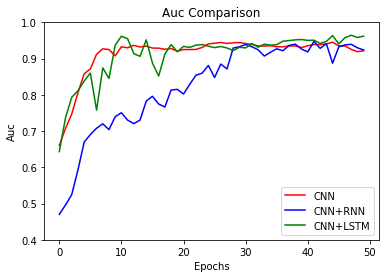

In [ ]:
# AUC

import matplotlib.pyplot as plt

CNN_auc = CNN_hist['val_auc'] [:50]
LSTM_auc = LSTM_hist['val_auc'] [:50]
RNN_auc = RNN_hist ['val_auc'] [:50]
epochs = range(50)

plt.plot(epochs, CNN_auc, 'r', label='CNN')
plt.plot(epochs, RNN_auc, 'b', label='CNN+RNN')
plt.plot(epochs, LSTM_auc, 'g', label='CNN+LSTM')

plt.title('Auc Comparison')
plt.xlabel('Epochs')
plt.ylabel('Auc')
plt.legend()
plt.ylim(ymax=1,ymin=0.4)

plt.show()



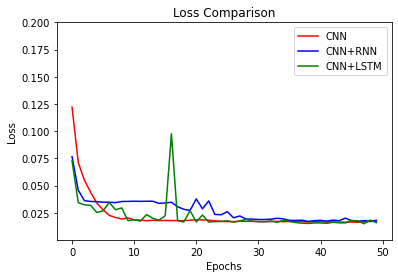

In [ ]:
## Loss

import matplotlib.pyplot as plt

CNN_loss = CNN_histy['val_loss'] [:50]
LSTM_loss = LSTM_hist['val_loss'] [:50]
RNN_loss = RNN_hist['val_loss'] [:50]
epochs = range(50)

plt.plot(epochs, CNN_loss, 'r', label='CNN')
plt.plot(epochs, RNN_loss, 'b', label='CNN+RNN')
plt.plot(epochs, LSTM_loss, 'g', label='CNN+LSTM')

plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(ymax=0.2,ymin=0.0001)

plt.show()


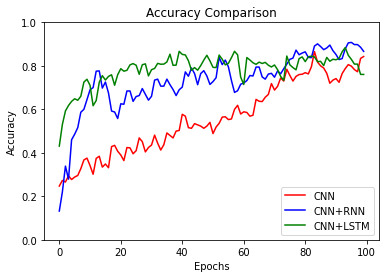

In [ ]:
## Accuracy

import matplotlib.pyplot as plt

CNN_accuracy = CNN_hist['accuracy'] [:50]
LSTM_accuracy = LSTM_hist['accuracy'] [:50]
RNN_accuracy = RNN_hist['accuracy'] [:50]
epochs = range(50)

plt.plot(epochs, CNN_accuracy, 'r', label='CNN')
plt.plot(epochs, RNN_accuracy, 'b', label='CNN+RNN')
plt.plot(epochs, LSTM_accuracy, 'g', label='CNN+LSTM')

plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(ymax=1,ymin=0)

plt.show()
